In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d #pre written interpolation function
from scipy.interpolate import griddata

In [2]:
def enum_other_states(n, num_step):
    """enumerate the state. using the following invariants
    (1) symetry (.1,.1,.8) is equivalent to (.1,.1,.8) from firm 1's pespective
    (2) the states must sum to 1"""
    
    states_i = np.arange(0,num_step+1)*(1./num_step)
    if n <=1:
        return states_i.reshape(num_step+1,1)
    else:
        states = []
        states_j = enum_other_states(n-1, num_step)
        for i in states_i:
            for j in states_j:
                if j[0] >= i and (j.sum() + i <= 1):
                    state_ij = np.concatenate( ([i],j) )
                    states.append(state_ij)
        states = np.array(states)
        return  states

In [3]:
class States:
    """class for dealing with the states to ensure
    invariants are kept"""
    
    my_states = None #type nparray
    other_states = None #type np array 2d
    n = 0 #number of players
    num_step = 0 #number of states (states normalized between 0 and 1)
    

    def __init__(self, n, num_step):
        """initialize important class attributes"""
        self.n, self.num_step = n, num_step
      
    
    def gen_states(self):
        """compute all relevant states for firm i (Avoiding side effects)
        the trick is enforcing invariants in the helper"""
        
        new_states = States(self.n, self.num_step)
        new_states.other_states =  enum_other_states(self.n-1, self.num_step)
        new_states.my_states = 1 - new_states.other_states.sum(axis=1)
        return new_states
        
    
    def get_len(self):
        return len(self.other_states)
    
    
    def get_all(self):
        """return all the states"""
        reshaped_states = self.my_states.reshape((len(self.my_states),1))
        return np.concatenate( (reshaped_states, self.other_states), axis=1 )
    
    
    def make_states(self, my_states, other_states):
        """special initializer for states enforcing the invariants"""
        
        assert np.array(other_states).shape[1] == (self.n -1)
        
        #make a copy to avoid side effects
        new_states = States(self.n, self.num_step)
        
        #combine into 1 array
        other_states = np.sort(other_states)
        my_states = np.array(my_states).reshape((len(my_states),1))
        all_states = np.concatenate((my_states,other_states),axis=1)
        all_states = np.maximum(0, all_states )

        #re-weight states
        denom = all_states.sum(axis=1)
        denom = np.repeat(denom,self.n).reshape(all_states.shape)
        all_states = all_states/denom
        
        #return states
        new_states.my_states = all_states[:,0]
        new_states.other_states = np.delete(all_states,0,axis=1)
        
        return new_states

In [68]:
def set_up_env(n, nsim, steps, contr, theta, beta, avg_cost):
    """generate reasonable parameters for simulations"""
    params = (contr, theta, beta)
    states = States(n, steps).gen_states()
    
    #set up shocks
    var_cost = 1.2/steps
    shocks = np.random.normal(avg_cost,var_cost,(nsim,n))
    
    #set up bids
    bsteps = int(1.2*steps)
    bid_weighting = (.8*theta + avg_cost + 3*var_cost)/(1.*bsteps)
    bids = np.arange(1,bsteps)*bid_weighting

    value = lambda state: 1 - state.my_states
    policy = lambda state, shock: 1.5*avg_cost + state.my_states + shock[:,0]
    
    return value, policy, bids, states, shocks, params, contr, theta, beta

value, policy, bids, states, shocks, params, contr, theta, beta = set_up_env(3, 5, 3, .3, 1, .9, 1)

In [69]:
def cost(states, shocks ,theta):
    """return the cost for firm 0"""
    return  shocks[:,0] + theta*states.my_states


def weighting(bids):
    """return weighting when there's a tie"""
    n_states, n_players = bids.shape
    low_bid =  np.min(bids,axis=1)
    low_bid = np.repeat(low_bid, n_players).reshape(n_states,n_players)
    
    #winners
    win = (bids <= low_bid)
    n_winners = win.sum(axis=1)*1.
    n_winners = np.repeat(n_winners, n_players).reshape(n_states,n_players)
    
    #add loosers
    lose = (bids > low_bid)
    n_loosers = np.maximum(lose.sum(axis=1)*1.,1.)
    n_loosers = np.repeat(n_loosers, n_players).reshape(n_states,n_players)
    
    return win/(1.*n_winners), lose/(1.*n_loosers)


def profit(bids, states, shocks, contract, theta):
    """return firm 0's profit"""
    my_bids = bids[:,0]
    win_weights, lose_weights = weighting(bids)
    profits = contract*win_weights[:,0]*(my_bids - cost(states,shocks,theta))  
    return profits


def update_state(bids, states, contract):
    """update all firms states based on bids
    note: firms in updated states, no longer correspond to their bids"""
    win_weights, lose_weights = weighting(bids)
    new_states = contract*win_weights - contract*lose_weights + states.get_all()
    return states.make_states(new_states[:,0],np.delete(new_states,0,axis=1))


def update_type(policy, states, type_shocks):
    pass

In [70]:
def calc_bids(policy, states, shocks):
    """return the other players bids given 
    the state by 'switching perspective' to other firm"""
    
    other_bids = []
    for i in range(1,states.n):
        other_states = states.get_all()
        my_other = other_states[:,i] #other states from i's perspective
        other = np.delete(other_states, i, axis=1)
        other_states = states.make_states(my_other, other)
        my_shocks = shocks.take(np.arange(states.n) + i, mode='wrap', axis=1)
        other_bids.append( policy(other_states,my_shocks) )
        
    return np.array(other_bids).transpose()

In [71]:
def gen_all_states(bids, states, shocks):
    """tile the states B x NSIM times"""
    
    #save lengths for later
    n_bids, n_shocks = bids.shape[0],shocks.shape[0]
    
    #repeat bids/states per each bid
    my_bids = np.repeat(bids,states.get_len()*n_shocks)
    
    shocks = np.repeat(shocks,states.get_len(), axis=0)
    shocks = np.tile(shocks,(n_bids,1))
    
    all_states = states.get_all()
    all_states = np.tile(all_states,(n_bids*n_shocks,1))
    all_states = states.make_states(all_states[:,0],np.delete(all_states,0,axis=1))
    
    return my_bids, all_states, shocks


def gen_all_shocks(states,shocks):
    """tile shocks NSIM times """
    n_shocks = shocks.shape[0]
    shocks = np.repeat(shocks,states.get_len(), axis=0)
    all_shocks = np.tile(states.get_all(),(n_shocks,1))   
    return np.concatenate((all_shocks,shocks),axis=1)

In [72]:
def simulation_helper(init_value, init_policy, bids, states, shocks, param):
    """ essentially, everytime this thing is called, 
    we are repeating a `step' in the  operator"""
    
    #unpack params
    contract, theta, beta = param
    n_bids, n_shocks = bids.shape[0],shocks.shape[0]
     
    #generate all bids x sims x states
    my_bids, all_states, all_shocks = gen_all_states(bids, states, shocks)
    
    #other bids in each bid state and concat with my bids
    other_bids = calc_bids(init_policy, all_states, all_shocks)
    all_bids = my_bids.reshape(all_states.get_len(),1)
    all_bids = np.concatenate((all_bids,other_bids), axis=1)

    #calculate see how the states would update
    next_states = update_state(all_bids, all_states, contract)
    
    #calculate the value of the next state
    new_value = profit(all_bids, all_states, all_shocks, contract, theta)
    new_value = new_value + beta*init_value(next_states)
        
    #reshape v_new to find argmax
    new_value = new_value.reshape((  n_bids, n_shocks, states.get_len() ))
    
    return new_value


def policy_lookup_helper(bids, states, shocks, value_matrix):
    """with all the policies, make look up easier. relies on value convergence
    return a lambda experession to make it easier to look up things in policy"""

    #unpack legnths
    n_bids, n_shocks, n_states = value_matrix.shape
    
    policy_matrix = value_matrix.reshape(n_bids, n_states*n_shocks )
    policy_matrix = np.argmax(policy_matrix ,axis=0)
    policy_matrix = bids[policy_matrix]
    all_shocks = gen_all_shocks(states, shocks)
    
    return lambda s0, e0: griddata(all_shocks, policy_matrix, 
                                     np.concatenate( (s0.get_all(),e0), axis=1), method='nearest',rescale=True)


def value_lookup_helper(states, value_matrix):
    """returns a function and its max values
    the function uses the grid data to figure out return value"""
    
    #unpack legnths
    value_matrix = value_matrix.max(axis=0) #max over bids (in each sim x state)
    value_matrix = value_matrix.mean(axis=0) #mean over sims
    return lambda s0: griddata(states.get_all(), value_matrix, s0.get_all(), method='nearest',rescale=True)

In [73]:
def operator(init_value, init_policy, bids, states, shocks, param):
    """evaluate states and shocks using look up function"""
    
    #calculate max
    new_value = simulation_helper(init_value, init_policy, bids, states, shocks, param)
    
    max_value = new_value.max(axis=0)
    max_value = np.amax( max_value.mean(axis=1) )

    value = value_lookup_helper(states, new_value)
    policy = policy_lookup_helper(bids, states, shocks, new_value)
    return max_value, value, policy


#set up 
#set up: n, nsim, steps, contr, theta, beta, avg_cost, var_cost
value, policy, bids, states, shocks, params, contr, theta, beta = set_up_env(3, 5, 3, .3, 1, .9, 1)

max_value, value, policy = operator(value, policy, bids, states, shocks, params)
max_value, value, policy = operator(value, policy, bids, states, shocks, params)

new_states = states.make_states([.3,.4],[[.3,.3],[.1,.3]])
print policy(new_states,[[0,0,0],[0,0,0]])

[2. 2.]


In [74]:
def  markov_perfect_eq(error, maxiter, init_value, init_policy, bids, states, shocks, param):
    """calculate the value function in a symmetric
        markov perfect equilibria"""
    
    #initialize loop variables
    value_conv = True #don't worry about value function for now
    init_max = -1 #ensure the loop goes once
    value, policy = init_value, init_policy
    
    while  maxiter >= 0 and value_conv :
        
        #iterate loop variables for each player first update value
        max_value, value, p_not = operator(value, policy, bids, states, shocks,  param)
        #then update value
        max_value, v_not, policy = operator(value, policy, bids, states, shocks,  param)    
        #update loop variables
        maxiter = maxiter - 1
        value_conv = np.abs(init_max - max_value) > error
        init_max = max_value
    
    return  value,  policy


#### testing
value, policy, bids, states, shocks, params, contr, theta, beta = set_up_env(3, 5, 3, .3, 1, .9, 1)

value,  policy = markov_perfect_eq(.01, 10, value, policy, bids, states, shocks, params)

new_states = states.make_states([.3,.4],[[.3,.3],[.1,.3]])

print policy(new_states,[[0,0,0],[0,0,0]])

[2. 2.]


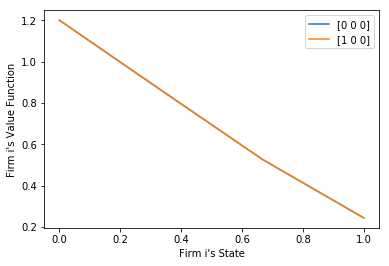

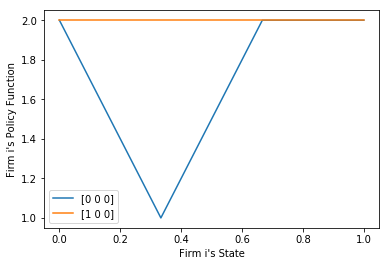

In [75]:
def gen_cross(states, graph_shocks):
    """gen cross section for purposes of graphing policy"""
    
    my_states = np.arange(0,states.num_step+1)*(1./states.num_step)

    #equalize other market shares
    other_shares = (1 - my_states)/(states.n-1)
    other_states = np.repeat(other_shares, states.n-1 )
    other_states = other_states.reshape(states.num_step + 1 , states.n-1)   
    cross_states = states.make_states(my_states,other_states)
    
    #then tile shocks based on states
    cross_shocks = []
    for i in range(len( graph_shocks)):
        cross_shock_i = np.tile(  graph_shocks[i], (cross_states.get_len(),1) )
        cross_shocks.append(cross_shock_i)

    return [cross_states]*len(cross_shocks), cross_shocks


def graph_functions(value, policy, cross_states, cross_shocks, labels):
    """graph function on predetermined cross section"""
    for l in labels:
        #set up labels
        fig = plt.figure()
        plt.xlabel("Firm i's State")
        plt.ylabel("Firm i's %s Function"%l)
        
        for i in range(len(cross_states)):
            #set y based on function
            func_eval = cross_states[i].my_states
            if l=='Value': func_eval =  value(cross_states[i])
            if l=='Policy': func_eval =  policy(cross_states[i],cross_shocks[i])
            plt.plot( cross_states[i].my_states, func_eval, label=str(cross_shocks[i][0]) )
            
        plt.legend()


 
#set up boring example to test
n, nsim, steps, contr, theta, beta, avg_cost = 3, 5, 3, .3, 1, .9, 1 
value, policy, bids, states, shocks, params, contr, theta, beta = (
    set_up_env(n, nsim, steps, contr, theta, beta, avg_cost))

value,  policy = markov_perfect_eq(.0001, 10, value, policy, bids, states, shocks, params)

graph_shocks = np.array([[0,0,0],[1,0,0]])
cross_states, cross_shocks = gen_cross(states, graph_shocks)

#roll the operator forward using shocks I intend to graph
bad_max, bad_value,  policy = operator(value,  policy, bids, states, graph_shocks, params)

graph_functions(bad_value, policy, cross_states, cross_shocks, ['Value','Policy'])

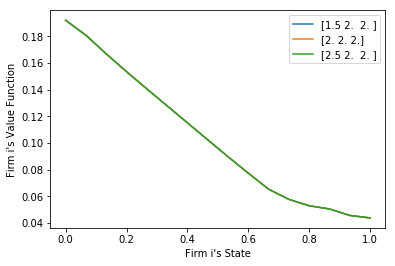

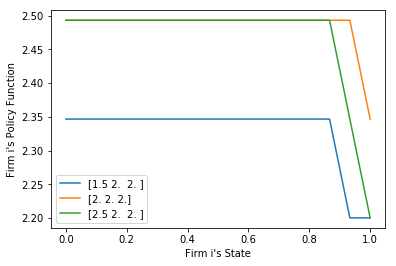

In [81]:
#Decreasing returns to scale (i.e. incumbency disadvantage


n, nsim, steps, contr, theta, beta, avg_cost = 3, 40, 15, .1, .5, .9, 2
value, policy, bids, states, shocks, params, contr, theta, beta = (
    set_up_env(n, nsim, steps, contr, theta, beta, avg_cost))


value,  policy = markov_perfect_eq(.001, 100, value, policy, bids, states, shocks, params)

#generate some states to graph
graph_shocks = np.array([[.75*avg_cost,avg_cost,avg_cost],[avg_cost]*n,[1.25*avg_cost,avg_cost,avg_cost]])
cross_states, cross_shocks = gen_cross(states, graph_shocks)

#roll the operator forward using shocks I intend to graph
bad_max, bad_value,  policy = operator(value,  policy, bids, states, graph_shocks, params)

graph_functions(value, policy, cross_states, cross_shocks, ['Value','Policy'])

In [82]:
n, nsim, steps, contr, theta, beta, avg_cost = 3, 40, 15, .1, .5, .9, 2
value, policy, bids, states, shocks, params, contr, theta, beta = (
    set_up_env(n, nsim, steps, contr, theta, beta, avg_cost))

print bids

[0.14666667 0.29333333 0.44       0.58666667 0.73333333 0.88
 1.02666667 1.17333333 1.32       1.46666667 1.61333333 1.76
 1.90666667 2.05333333 2.2        2.34666667 2.49333333]


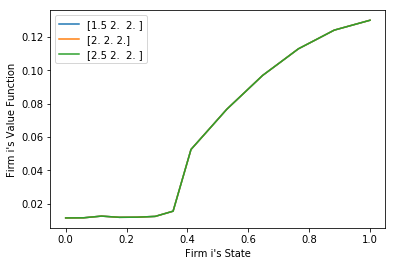

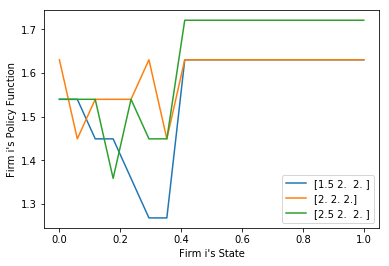

In [83]:
#incumbency advantage here

n, nsim, steps, contr, theta, beta, avg_cost = 3, 50, 17, .1, -.5, .9, 2
value, policy, bids, states, shocks, params, contr, theta, beta = (
    set_up_env(n, nsim, steps, contr, theta, beta, avg_cost))

#try to generate something weird
policy = lambda state, shock: state.my_states + shock[:,0]

value,  policy = markov_perfect_eq(.001, 100, value, policy, bids, states, shocks, params)

#generate some states to graph
graph_shocks = np.array([[.75*avg_cost,avg_cost,avg_cost],[avg_cost]*n,[1.25*avg_cost,avg_cost,avg_cost]])
cross_states, cross_shocks = gen_cross(states, graph_shocks)

#roll the operator forward using shocks I intend to graph
bad_max, bad_value,  policy = operator(value,  policy, bids, states, graph_shocks, params)
graph_functions(value, policy, cross_states, cross_shocks, ['Value','Policy'])